## Breaking Down Strategy Performance to Trade Level

In [1]:
import warnings

In [2]:
import pandas as pd
import pyfolio as pf
from IPython.display import Markdown, display
from openbb import obb

In [3]:
warnings.filterwarnings("ignore")
obb.user.preferences.output_type = "dataframe"

Load the mean reversion performance data

In [4]:
perf = pd.read_pickle("mean_reversion.pickle")

Extract returns, positions, and transactions from Zipline performance DataFrame

In [5]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

Rename position columns to stock symbols and cash

In [6]:
positions.columns = [col.symbol for col in positions.columns[:-1]] + ["cash"]

Get the list of symbols

In [7]:
symbols = positions.columns[:-1].tolist()

Get screener data for the symbols

In [8]:
screener_data = obb.equity.profile(symbols, provider="yfinance")

Create a sector map from the screener data

In [9]:
sector_map = (
    screener_data[["symbol", "sector"]]
    .set_index("symbol")
    .reindex(symbols)
    .fillna("Unknown")
    .to_dict()["sector"]
)

Get historical price data for SPY

In [10]:
spy = obb.equity.price.historical(
    "SPY",
    start_date=returns.index.min(),
    end_date=returns.index.max(),
    provider="yfinance",
)

Convert the index to datetime and calculate the benchmark returns

In [11]:
spy.index = pd.to_datetime(spy.index)
benchmark_returns = spy.close.pct_change()
benchmark_returns.name = "SPY"
benchmark_returns = benchmark_returns.tz_localize("UTC").filter(returns.index)

Extract round trips from transactions

In [12]:
round_trips = pf.round_trips.extract_round_trips(
    transactions[["amount", "price", "symbol"]]
)

Display the round trips

In [13]:
display(round_trips)

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration
0,-29.89,2016-05-17 20:00:00+00:00,2016-05-24 20:00:00+00:00,True,-0.015012,Equity(2 [AAL]),7 days 00:00:00
1,78.10,2016-07-19 20:00:00+00:00,2016-08-09 20:00:00+00:00,False,0.039433,Equity(2 [AAL]),21 days 00:00:00
2,57.12,2016-05-03 20:00:00+00:00,2016-05-24 20:00:00+00:00,True,0.028577,Equity(8 [AAPL]),21 days 00:00:00
3,-16.51,2017-06-20 20:00:00+00:00,2017-06-27 20:00:00+00:00,True,-0.008758,Equity(8 [AAPL]),7 days 00:00:00
4,35.88,2017-09-26 20:00:00+00:00,2017-10-10 20:00:00+00:00,True,0.018023,Equity(8 [AAPL]),14 days 00:00:00
...,...,...,...,...,...,...,...
254,-2.86,2016-01-26 21:00:00+00:00,2016-02-02 21:00:00+00:00,False,-0.044688,Equity(3105 [WMT]),7 days 00:00:00
255,-54.30,2016-01-26 21:00:00+00:00,2016-02-09 21:00:00+00:00,False,-0.028281,Equity(3105 [WMT]),14 days 00:00:00
256,-40.39,2017-01-18 21:00:00+00:00,2017-01-31 21:00:00+00:00,True,-0.019774,Equity(3105 [WMT]),13 days 00:00:00
257,28.62,2017-02-28 21:00:00+00:00,2017-03-07 21:00:00+00:00,False,0.014944,Equity(3105 [WMT]),7 days 00:00:00


Print round trip stats

In [14]:
pf.round_trips.print_round_trip_stats(
    round_trips.rename(columns={"rt_returns": "returns"})
)

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,259.00,116.00,143.00
Percent profitable,0.56,0.46,0.64
Winning round_trips,145.00,53.00,92.00
Losing round_trips,114.00,63.00,51.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$861.37,$-599.93,$1461.30
Gross profit,$8204.94,$2347.53,$5857.41
Gross loss,$-7343.57,$-2947.46,$-4396.11
Profit factor,$1.12,$0.80,$1.33
Avg. trade net profit,$3.33,$-5.17,$10.22
Avg. winning trade,$56.59,$44.29,$63.67
Avg. losing trade,$-64.42,$-46.79,$-86.20
Ratio Avg. Win:Avg. Loss,$0.88,$0.95,$0.74
Largest winning trade,$374.66,$167.40,$374.66
Largest losing trade,$-889.20,$-258.42,$-889.20


Duration stats,All trades,Short trades,Long trades
Avg duration,12 days 10:42:51.428571428,12 days 03:47:04.137931034,12 days 16:20:08.391608391
Median duration,8 days 00:00:00,8 days 00:00:00,8 days 00:00:00
Longest duration,35 days 01:00:00,29 days 00:00:00,35 days 01:00:00
Shortest duration,6 days 00:00:00,6 days 00:00:00,6 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.26%,-0.46%,0.84%
Avg returns winning,3.18%,2.26%,3.71%
Avg returns losing,-3.46%,-2.74%,-4.35%
Median returns all round_trips,0.31%,-0.21%,0.86%
Median returns winning,2.03%,1.60%,2.50%
Median returns losing,-2.29%,-2.28%,-2.42%
Largest winning trade,19.68%,8.31%,19.68%
Largest losing trade,-46.94%,-15.00%,-46.94%


Symbol stats,AAL,AAPL,ABBV,ADBE,ADP,AET,AGN,AIG,ALXN,AMAT,AMGN,AMZN,ANTM,ARIA,ATVI,AVGO,AXP,AZO,BA,BBY,BCR,BIDU,BIIB,BMY,BRK_B,CCE,CELG,CHTR,CL,CMCSA,CMG,COL,COST,CSCO,CSX,CTSH,CVS,DAL,DE,DG,DVN,EA,EBAY,EFX,ESRX,EXPE,F,FB,GE,GILD,GM,GMCR,GOOG,GS,HAL,HD,HON,HUM,IBM,INCY,INTC,JNJ,KMI,KO,KR,LLY,LMT,LNKD,LOW,LRCX,M,MA,MCD,MCK,MDLZ,MDT,MJN,MMM,MO,MON,MRK,MRO,MS,MSFT,MU,MYL,NFLX,NKE,NVDA,ORCL,ORLY,OXY,PANW,PCG,PCLN,PEP,PFE,PG,PM,PNRA,PRGO,PXD,PYPL,QCOM,RAI,REGN,SBUX,SCHW,SLB,SNI,SRPT,STJ,SYF,T,TDG,TGT,TJX,TSLA,TWTR,TWX,TXN,UNH,UPS,USB,VRX,VZ,WBA,WDC,WFC,WFM,WMT
Avg returns all round_trips,1.22%,1.26%,-2.22%,-2.47%,4.93%,-0.32%,1.53%,1.20%,3.59%,4.21%,6.22%,-1.52%,-0.72%,-0.55%,0.99%,1.74%,-4.47%,-0.93%,0.11%,4.15%,-0.22%,2.22%,-0.69%,-3.71%,-1.84%,-10.67%,-15.12%,1.19%,-0.99%,0.76%,-5.04%,0.15%,-1.81%,0.91%,-3.22%,-4.43%,1.89%,-6.93%,4.96%,-4.99%,6.85%,2.96%,-0.13%,11.92%,-2.80%,0.82%,1.77%,-0.82%,-3.98%,-1.05%,-1.30%,-0.58%,-0.45%,-2.17%,1.15%,-0.17%,3.11%,12.44%,-1.83%,-0.55%,-0.66%,-1.51%,0.27%,-1.12%,2.27%,3.37%,1.34%,7.47%,0.41%,11.80%,-0.12%,2.64%,-1.41%,-1.01%,0.12%,-1.71%,-0.00%,0.04%,0.23%,-4.11%,0.55%,8.05%,3.74%,0.14%,3.45%,1.49%,3.05%,-1.18%,1.84%,0.49%,-0.11%,5.83%,-2.70%,-0.88%,2.76%,2.14%,-1.42%,2.76%,0.41%,0.25%,0.82%,4.00%,-1.85%,-0.92%,2.35%,0.50%,-0.60%,4.52%,2.50%,2.25%,7.12%,-3.66%,1.18%,-0.32%,5.85%,-1.37%,-0.76%,-1.58%,-0.47%,-2.35%,-0.22%,2.09%,1.57%,1.33%,-10.95%,0.26%,-2.54%,0.54%,3.95%,1.88%,-1.29%
Avg returns winning,3.94%,2.33%,NaN,2.39%,4.93%,0.42%,1.53%,2.89%,7.29%,6.42%,6.22%,NaN,NaN,NaN,3.05%,1.74%,NaN,2.29%,0.11%,4.15%,NaN,2.22%,4.06%,0.67%,NaN,NaN,NaN,1.95%,NaN,0.76%,NaN,0.15%,NaN,0.91%,NaN,NaN,3.70%,NaN,4.96%,NaN,6.85%,2.96%,NaN,15.96%,NaN,0.82%,1.77%,NaN,3.25%,0.61%,0.22%,NaN,1.99%,NaN,3.22%,1.96%,3.11%,12.44%,1.17%,NaN,1.21%,NaN,0.27%,NaN,2.27%,6.91%,1.34%,7.47%,0.41%,11.80%,NaN,2.64%,0.37%,0.96%,0.12%,NaN,0.61%,0.87%,1.44%,3.64%,1.87%,8.05%,3.74%,1.32%,3.45%,1.49%,3.05%,NaN,4.14%,1.18%,11.52%,5.83%,NaN,NaN,2.76%,2.14%,0.06%,2.76%,5.18%,0.25%,0.82%,4.00%,NaN,6.87%,2.35%,0.50%,0.77%,4.52%,2.50%,2.25%,7.12%,NaN,1.18%,0.81%,5.85%,0.11%,1.38%,2.74%,2.75%,NaN,3.95%,2.09%,1.57%,1.33%,3.18%,0.99%,NaN,2.76%,3.95%,1.88%,2.93%
Avg returns losing,-1.50%,-0.88%,-2.22%,-7.33%,NaN,-1.06%,NaN,-0.48%,-3.82%,-2.42%,NaN,-1.52%,-0.72%,-0.55%,-1.08%,NaN,-4.47%,-4.16%,NaN,NaN,-0.22%,NaN,-7.81%,-8.08%,-1.84%,-10.67%,-15.12%,-1.87%,-0.99%,NaN,-5.04%,NaN,-1.81%,NaN,-3.22%,-4.43%,-3.53%,-6.93%,NaN,-4.99%,NaN,NaN,-0.13%,-0.20%,-2.80%,NaN,NaN,-0.82%,-11.21%,-4.36%,-2.81%,-0.58%,-2.90%,-2.17%,-0.92%,-2.30%,NaN,NaN,-4.83%,-0.55%,-1.59%,-1.51%,NaN,-1.12%,NaN,-0.17%,NaN,NaN,NaN,NaN,-0.12%,NaN,-3.18%,-2.98%,NaN,-1.71%,-0.62%,-1.61%,-2.19%,-11.85%,-2.09%,NaN,NaN,-1.05%,NaN,NaN,NaN,-1.18%,-2.76%,-0.89%,-11.74%,NaN,-2.70%,-0.88%,NaN,NaN,-2.91%,NaN,-1.98%,NaN,NaN,NaN,-1.85%,-3.52%,NaN,NaN,-1.28%,NaN,NaN,NaN,NaN,-3.66%,NaN,-2.00%,NaN,-2.11%,-5.05%,-5.90%,-3.68%,-2.35%,-4.39%,NaN,NaN,NaN,-25.07%,-0.84%,-2.54%,-3.89%,NaN,NaN,-3.40%
Median returns all round_trips,1.22%,1.80%,-2.22%,-2.47%,4.93%,-0.32%,1.53%,1.20%,4.42%,4.29%,6.22%,-1.52%,-0.72%,-0.55%,0.60%,0.94%,-4.47%,-0.93%,0.11%,4.15%,-0.22%,2.22%,0.32%,-3.71%,-1.84%,-10.67%,-15.12%,0.39%,-0.99%,0.76%,-3.92%,0.15%,-1.81%,0.91%,-3.22%,-4.43%,2.63%,-6.93%,4.96%,-4.99%,6.85%,2.96%,-0.13%,14.10%,-2.80%,0.82%,1.77%,-0.81%,-3.98%,0.42%,-1.30%,-0.58%,-0.45%,-2.17%,1.15%,-0.17%,3.11%,12.44%,-1.83%,-0.55%,-0.35%,-1.51%,0.27%,-1.12%,2.27%,3.37%,1.34%,7.47%,0.41%,11.80%,-0.12%,2.64%,-0.96%,-1.01%,0.12%,-1.71%,-0.00%,0.06%,0.36%,-4.11%,1.23%,8.05%,3.74%,0.14%,1.69%,1.49%,3.05%,-0.37%,1.03%,0.33%,-0.29%,5.83%,-2.70%,-0.88%,2.76%,2.14%,-1.42%,2.76%,-1.10%,0.25%,0.82%,4.00%,-1.85%,-1.94%,2.35%,0.50%,-0.07%,4.52%,2.50%,2.25%,7.12%,-3.66%,1.18%,0.03%,5.85%,-1.39%,1.01%,-1.58%,-0.21%,-2.35%,-0.22%,2.09%,1.57%,1.33%,-1.45%,0.48%,-2.54%,1.44%,3.95%,1.88%,-2.40%
Median returns winning,3.94%,2.33%,NaN,2.39%,4.93%,0.42%,1.53%,2.89%,7.29%,7.80%,6.22%,NaN,NaN,NaN,3.05%,0.94%,NaN,2.29%,0.11%,4.15%,NaN,2.22

Plot round trip lifetimes

<Axes: >

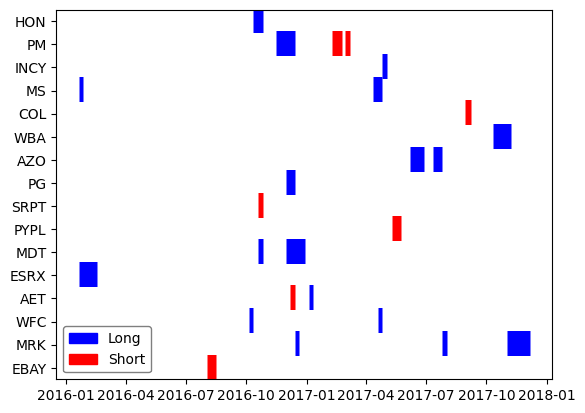

In [15]:
pf.plotting.plot_round_trip_lifetimes(round_trips)

Apply sector mappings to round trips

In [16]:
round_trips_by_sector = pf.round_trips.apply_sector_mappings_to_round_trips(
    round_trips, sector_map
)

Display the round trips by sector

In [17]:
display(round_trips_by_sector)

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration
0,-29.89,2016-05-17 20:00:00+00:00,2016-05-24 20:00:00+00:00,True,-0.015012,No Sector Mapping,7 days 00:00:00
1,78.10,2016-07-19 20:00:00+00:00,2016-08-09 20:00:00+00:00,False,0.039433,No Sector Mapping,21 days 00:00:00
2,57.12,2016-05-03 20:00:00+00:00,2016-05-24 20:00:00+00:00,True,0.028577,No Sector Mapping,21 days 00:00:00
3,-16.51,2017-06-20 20:00:00+00:00,2017-06-27 20:00:00+00:00,True,-0.008758,No Sector Mapping,7 days 00:00:00
4,35.88,2017-09-26 20:00:00+00:00,2017-10-10 20:00:00+00:00,True,0.018023,No Sector Mapping,14 days 00:00:00
...,...,...,...,...,...,...,...
254,-2.86,2016-01-26 21:00:00+00:00,2016-02-02 21:00:00+00:00,False,-0.044688,No Sector Mapping,7 days 00:00:00
255,-54.30,2016-01-26 21:00:00+00:00,2016-02-09 21:00:00+00:00,False,-0.028281,No Sector Mapping,14 days 00:00:00
256,-40.39,2017-01-18 21:00:00+00:00,2017-01-31 21:00:00+00:00,True,-0.019774,No Sector Mapping,13 days 00:00:00
257,28.62,2017-02-28 21:00:00+00:00,2017-03-07 21:00:00+00:00,False,0.014944,No Sector Mapping,7 days 00:00:00


Plot round trip lifetimes by sector

<Axes: >

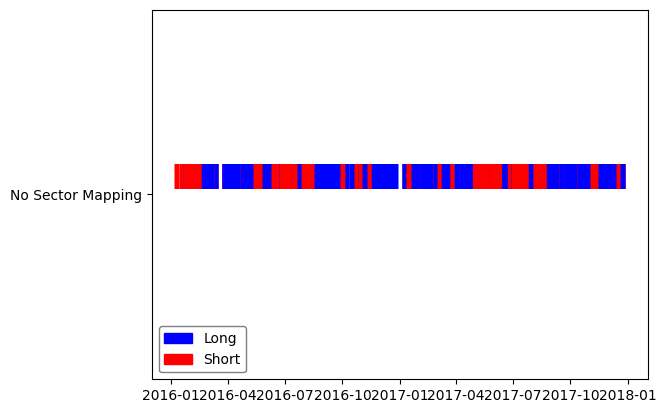

In [18]:
pf.plotting.plot_round_trip_lifetimes(
    round_trips_by_sector.rename(columns={"rt_returns": "returns"})
)

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.